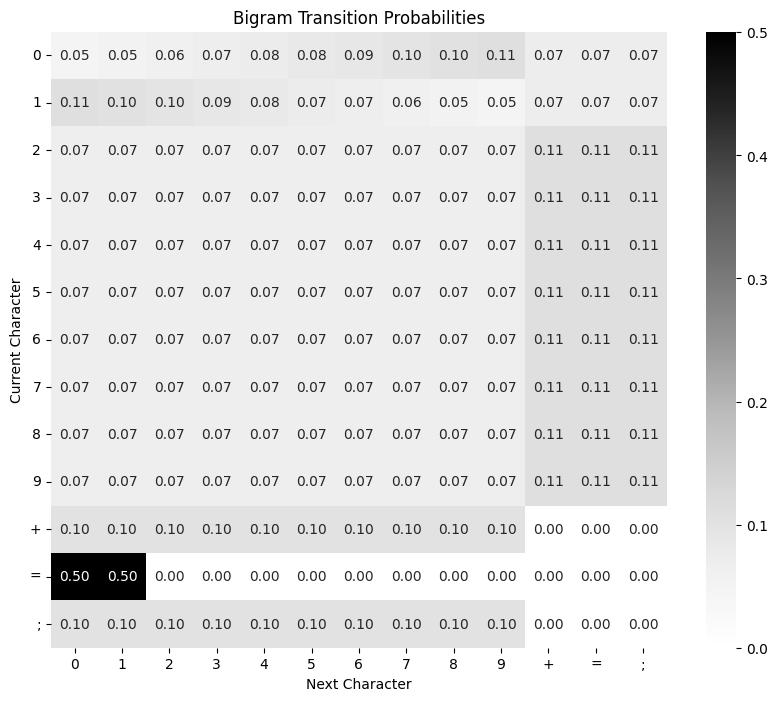

In [143]:
from itertools import product
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

digits = range(1000)
equations = [
    f"{a:03}+{b:03}={a+b:04}"
    for a, b in product(digits, repeat=2)
]
corpus = ";".join(equations)

vocab = list("0123456789+=;")
vocab_size = len(vocab)
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

bigram_counts = Counter()
for i in range(len(corpus) - 1):
    current_char = corpus[i]
    next_char = corpus[i + 1]
    bigram_counts[(current_char, next_char)] += 1

bigram_probs = np.zeros((vocab_size, vocab_size))
for (current_char, next_char), count in bigram_counts.items():
    current_idx = char_to_idx[current_char]
    next_idx = char_to_idx[next_char]
    bigram_probs[current_idx, next_idx] = count

bigram_probs = bigram_probs / bigram_probs.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    bigram_probs, 
    cmap="Greys",
    square=True, 
    annot=True,
    fmt=".2f",
    xticklabels=[idx_to_char[i] for i in range(vocab_size)],
    yticklabels=[idx_to_char[i] for i in range(vocab_size)]
)
ax.set_title("Bigram Transition Probabilities")
ax.set_xlabel("Next Character")
ax.set_ylabel("Current Character")
plt.yticks(rotation=0)
plt.show()

In [145]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from collections import Counter
import seaborn as sns


digits = range(1000)
equations = [
    f"{a:03}+{b:03}={a+b:04}"
    for a, b in product(digits, repeat=2)
]

def is_neighbor(equation, candidate):
    a, b = equation.split("+")
    b, _ = b.split("=")

    candidate_a, candidate_b = candidate.split("+")
    candidate_b, _ = candidate_b.split("=")

    diff_count = 0

    for x, y in zip(a, candidate_a):
        if x != y:
            diff_count += 1
            if diff_count > 1:
                return False

    for x, y in zip(b, candidate_b):
        if x != y:
            diff_count += 1
            if diff_count > 1:
                return False

    return diff_count == 1


def nearest_neighbor_prediction(equation, train_set):
    _, result = equation.split("=")
    neighbors = []
    for train_eq in train_set:
        if is_neighbor(equation, train_eq):
            _, train_result = train_eq.split("=")
            neighbors.append(train_result)
    
    if not neighbors:
        raise ValueError("No neighbors found in the training set.")
    
    digit_counts = [Counter() for _ in range(len(result))]
    for neighbor_result in neighbors:
        for i, digit in enumerate(neighbor_result):
            digit_counts[i][digit] += 1

    predicted_result = "".join([digit_counts[i].most_common(1)[0][0] for i in range(len(result))])
    return predicted_result == result

def simulate(equations, train_percentages, max_equations):
    results = []
    total_equations = len(equations)
    
    for train_percentage in train_percentages:
        print(train_percentage)
        train_size = int(total_equations * train_percentage / 100)
        train_set = random.sample(equations, train_size)
        
        test_set = random.sample(equations, max_equations)
        success_count = 0
        for i in range(1, max_equations):
            if nearest_neighbor_prediction(test_set[i], train_set):
                success_count += 1
            
            success_rate = success_count / i
            results.append({
                "Train Percentage": train_percentage,
                "Equations Used": i,
                "Success Rate": success_rate
            })

    return pd.DataFrame.from_records(results)

train_percentages = [10, 15, 20, 50]
max_equations = 100 
results_df = simulate(equations, train_percentages, max_equations)
print(equations[:10], train_percentages, max_equations)

10
15
20
50
['000+000=0000', '000+001=0001', '000+002=0002', '000+003=0003', '000+004=0004', '000+005=0005', '000+006=0006', '000+007=0007', '000+008=0008', '000+009=0009'] [10, 15, 20, 50] 100


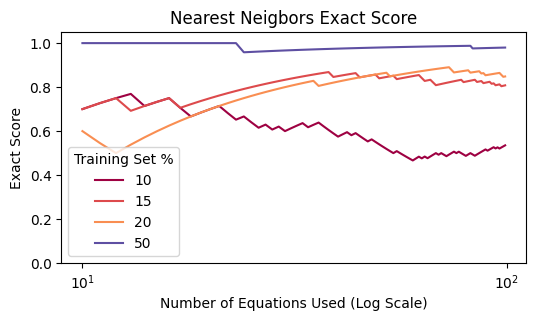

In [154]:
plt.figure(figsize=(6, 3))
palette = sns.color_palette("Spectral", as_cmap=True)
lw = 1.0
ax = sns.lineplot(
    data=results_df[(results_df["Equations Used"]>=10)&(results_df["Train Percentage"]<80)], 
    x="Equations Used", 
    y="Success Rate", 
    hue="Train Percentage",
    palette=palette
)
plt.title("Nearest Neigbors Exact Score")
plt.xlabel("Number of Equations Used (Log Scale)")
plt.ylabel("Exact Score")
ax.grid(False, axis='y')
plt.xscale("log")
plt.ylim(0, 1.05)
plt.minorticks_off()
plt.legend(title="Training Set %", loc="lower left")
plt.show()